#Qui sont les traders haute fréquence ?

## Introduction au problème

### Contexte : THF & AMF


*   Cadre du régulateur français des marchés financiers AMF
*   Développement du trading à haute fréquence (THF) ces 10 dernières années
*   THF disposent d’infrastructures IT ultra-réactives pour réaliser de larges transactions en quelques fractions de secondes et arbitrer le marché
*   Les traders utilisent des carnets d’ordre pour acheter ou vendre une certaine quantité d’un actif à un certain prix. Ils peuvent modifier les prix ou quantité des ordres tant qu’ils restent dans le carnet ou les annuler
*   Intérêt : important pour l’AMF de connaitre le type d’acteur sur le marché afin de mieux comprendre leurs comportements et les impacts possibles

### Objectif du projet : un problème de classification

*   L’objectif est de classifier les traders en 3 catégories définies par
l’AMF :
      *   THF
      *   Non THF
      *   MIX (parfois THF, parfois non)
*   En utilisant des variables liées aux comportements des agents,
avec des données sur les ordres passés et transactions
*   Cela pourrait permettre à l’AMF de classer rapidement et
efficacement des acteurs du marché nouveaux ou peu connus

### Jeu de données : description

Le jeu de données se concentre sur les marchés actions qui peuvent être traités sur différentes plateformes de négociation. Les THF cherchent à arbitrer les moindres écarts de prix entre ces plateformes. Ils envoient donc une quantité d’ordres, de modifications ou d’annulations plus importante que les autres acteurs ainsi que des ordres successifs très rapprochés.

*   Chaque acteur $i$ est représenté par une matrice $X_i$ dont les lignes $r_{a,t}$ correspondent à des variables comportementales pour l’action $a$ à la date $t$. La taille est variable car tous les acteurs ne traitent pas les mêmes jours et pas sur le même univers 
*   Il faut trouver une fonction $f(X_i) = y$, telle que $y = ⟨HF T|MIX|nonHF T⟩$
*   Notre jeu de données contient 35 features et un total de 105782 lignes répartient en 22 jours, 119 actions pour 86 acteurs.

### Jeu de données : features

$X$ dispose de 35 features, pour chaque acteur du marché $i$, chaque actif $j$ et chaque date $t$, on dispose de :

*   nombre de plateformes utilisé par $i$
*   nombre (moyen, max) de trades de $i$ sur l’ensemble des plateformes
*   nombre de trade (OTR), d'annulation (OCR), de modification (OMR)
*   time delta (min, médiane, max) entre 2 trades de $i$ sur la plateforme 1, et entre la plateforme 1-2, 1-3, 1-4
*   nombre de secondes sur la journée $t$ où au moins un trade de $i$ peut être observé
*   Sur la plateforme 1, statistiques sur le time delta entre 2 évenements de $i$ (min, moyenne, 10e centile, 1er quartile, médiane, 3e quartile, 90e centile, max)
*   Sur la plateforme 1, statistiques sur le temps de vie des ordres annulés par $i$ (min, moyenne, 10e centile, 1er quartile, médiane, 3e quartile, 90e centile, max)

### Application

Afin de réaliser la classification des traders nous procéderons en 2 classification successives. Dans un premier temps nous chercherons à classifier chaque ligne. Pour cette première classification nous chercherons un modèle optimale permettant de réaliser le moins d'erreurs possibles.
Puis avec les résultats des lignes pour chaque trader nous réaliserons une dernière classification avec un modèle simple.

## Import des bibliothèques

In [ ]:
# Usual Librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

# sklearn Librairies
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

## Chargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# From local
# Read data with pandas
X = pd.read_csv("/content/AMF_train_X.csv", index_col=0)
y = pd.read_csv("/content/AMF_train_Y.csv", index_col=0)
X_val = pd.read_csv("/content/AMF_test_X.csv", index_col=0)

In [ ]:
# From Drive
# Read data with pandas
X = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_train_X.csv", index_col=0)
y = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_train_Y.csv", index_col=0)
X_val = pd.read_csv("/content/drive/MyDrive/ML python ENSAE/AMF_test_X.csv", index_col=0)

## I) Analyse du jeu de données

On remarque que le nombre de données par trader n'est pas équilibrée. Certain ont près de 10 000 lignes tandis que d'autres une seule. 

### Data cleaning

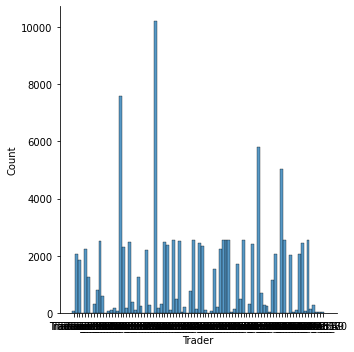

In [ ]:
# Distribution of the target variable
%matplotlib inline

sns.displot(X, x="Trader")

Nous remarquons que certaines lignes sont présentes plusieurs fois dans la matrice X. Nous supprimons les doublons. Le nombre d'observations par trader apparait être bien plus équilibré

#### Supression des doublons

In [ ]:
#Suppression des doublons (20 000 raws)
X.drop_duplicates(inplace=True)

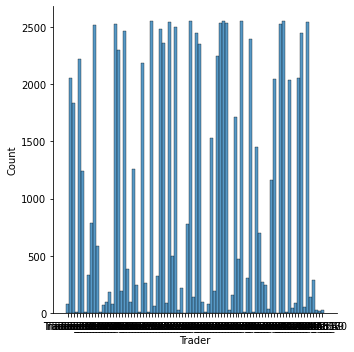

In [ ]:
# Distribution of the target variable
%matplotlib inline

sns.displot(X, x="Trader")

#### Description du jeu de données

In [ ]:
# Description de X
X.describe()

,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
count,84445.000000,86074.000000,48124.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,86074.000000,81964.000000,81964.000000,81964.000000,61302.000000,61302.000000,61302.000000,61238.000000,61238.000000,61238.000000,61352.000000,61352.000000,61352.000000,86074.000000
mean,32.346457,19.042374,176.012051,95.913568,2631.838362,114.148185,962.391263,251.376997,4210.696394,8881.408372,22010.848017,2203.253800,5424.200612,2284.711764,4259.634045,2788.862010,7704.477171,10502.767872,17220.947246,5.184527,22.603643,2.087883,533.205475,1255.506337,770.097689,369.617222,693.199639,470.129230,385.351739,698.894907,483.501603,383.546857,709.166783,483.444480,295.189395
std,137.041090,78.823869,1000.315633,1597.127673,4872.048635,1666.481302,4801.519293,2410.145876,9575.023991,13442.732129,17632.708254,7054.431752,9079.576436,7120.164069,8985.266471,7568.943636,12477.839879,14993.134768,17031.920395,4.560571,31.210746,1.544121,3178.010108,3494.492099,3231.064602,2103.308444,2228.981050,2113.963774,2151.528005,2254.640399,2157.959406,2134.747946,2257.561682,2143.907147,598.476189
min,1.044444,2.000000,1.001960,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,0.000007,0.000038,0.000016,0.000035,0.000028,0.000038,0.000038,0.000038,1.000000,1.000000,1.000000,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000003,0.000002,0.000001,0.000008,0.000003,1.000000
25%,3.451613,2.819390,3.732570,0.000000,63.576481,0.000000,1.082370,0.000020,21.030420,108.986442,2965.041500,0.000607,59.744087,0.046170,6.239885,0.724871,31.417616,103.227454,1157.662300,1.000000,5.000000,1.454545,0.000016,58.654166,5.803634,0.000006,40.430191,4.933250,0.000007,39.954081,4.991631,0.000029,40.764153,5.123669,19.000000
50%,6.227273,5.352158,18.750000,0.000000,238.445440,0.000084,10.060561,0.068562,107.800300,406.287595,24258.458000,0.039160,230.294451,2.169797,37.993283,9.486376,174.372470,491.556175,11449.344500,4.000000,13.000000,1.839598,0.000328,222.408997,47.337398,0.001000,129.166022,31.707000,0.001000,129.475282,32.833173,0.001000,131.004460,32.445670,80.000000
75%,20.286667,17.940357,84.000000,0.000000,3504.897269,0.007348,61.582020,2.941342,1839.829550,17683.567750,35726.220750,46.408684,8592.722642,84.349146,1974.212475,278.388722,15294.310250,22175.417750,30588.085250,8.000000,27.000000,2.297761,0.002000,858.055648,283.103064,0.393793,424.824646,159.428461,1.045295,428.868542,164.314484,1.333019,435.634114,164.489500,293.000000
max,17561.000000,14409.000000,127861.000000,52568.766000,52568.765625,52568.766000,52568.766000,52568.766000,60597.414000,60609.660000,71934.490000,53171.766000,53171.765625,53171.766000,53171.766000,53171.766000,53646.010000,53909.210000,53909.210000,24.000000,909.000000,63.000000,30929.771000,30929.771000,30929.771000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,12966.000000


#### Ajout de features facilitant l'analyse

In [ ]:
#Création du data Frame data regroupant X et y et ajout des variables y comme binaires
data=X.copy()

data['type'] = np.nan
data['HFT'] = np.nan
data['NON_HFT'] = np.nan
data['MIX'] = np.nan

for indiv in y.index:
  data.loc[X.loc[:,'Trader']==indiv,'type'] = y[y.index==indiv].values[0][0]

data.loc[:,'HFT'] =  pd.Series(data.loc[:,'type']=='HFT')
data.loc[:,'NON_HFT'] =  pd.Series(data.loc[:,'type']=='NON HFT')
data.loc[:,'MIX'] =  pd.Series(data.loc[:,'type']=='MIX')

In [ ]:
# Ajout de features pour TV1_TVX, elles correspondent aux moyennes des transactions

data['min_dt_TV1_TVX'] = np.nan
data['mean_dt_TV1_TVX'] = np.nan
data['med_dt_TV1_TVX'] = np.nan

data.loc[:,'min_dt_TV1_TVX'] =  data[['min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']].mean(axis=1)
data.loc[:,'mean_dt_TV1_TVX'] =  data[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].mean(axis=1)
data.loc[:,'med_dt_TV1_TVX'] =  data[['med_dt_TV1_TV2','med_dt_TV1_TV3','med_dt_TV1_TV4']].mean(axis=1)

#### Analyse des NaN

In [ ]:
#Pourcentage de NaN dans les données
print("\n Pourcentage de NaN dans les données")
print(data.isna().sum()/data.shape[0]*100)

#Pourcentage de NaN dans les données MIX
print("\n Pourcentage de NaN pour MIX")
print(data[data['type']=='MIX'].isna().sum()/data[data['type']=='MIX'].shape[0]*100)

#Pourcentage de NaN dans les données HFT
print("Pourcentage de NaN pour HFT")
print(data[data['type']=='HFT'].isna().sum()/data[data['type']=='HFT'].shape[0]*100)

#Pourcentage de NaN dans les données NON HFT
print("Pourcentage de NaN pour NON HFT")
print(data[data['type']=='NON HFT'].isna().sum()/data[data['type']=='NON HFT'].shape[0]*100)


 Pourcentage de NaN dans les données
Share                          0.000000
Day                            0.000000
Trader                         0.000000
OTR                            1.892558
OCR                            0.000000
OMR                           44.089969
min_time_two_events            0.000000
mean_time_two_events           0.000000
10_p_time_two_events           0.000000
med_time_two_events            0.000000
25_p_time_two_events           0.000000
75_p_time_two_events           0.000000
90_p_time_two_events           0.000000
max_time_two_events            0.000000
min_lifetime_cancel            0.000000
mean_lifetime_cancel           0.000000
10_p_lifetime_cancel           0.000000
med_lifetime_cancel            0.000000
25_p_lifetime_cancel           0.000000
75_p_lifetime_cancel           0.000000
90_p_lifetime_cancel           0.000000
max_lifetime_cancel            0.000000
NbTradeVenueMic                0.000000
MaxNbTradesBySecond            0.000000
Me

On remarque que beaucoup de données sont manquante.

Pour OMR et OTR elles correspondent à des 0.
Pour TV1_TVX à une non participation du trader à d'autres plateformes.

Hormis ces variables, aucune autre n'est manquante.

#### FILLNA

Afin de compléter le jeu de données et en exploiter son plein potentiel nous choisissons de remplir le NA.

In [ ]:
# On remarque que ces variables ne comportent pas de 0 il faut remplacer les NaN (pas de d'annulation/modification de transaction)
data['OMR'].fillna(0,inplace=True)
data['OTR'].fillna(0,inplace=True)

Pour les annulations ou modifications d'ordre manquante nous les remplaçons par 0.

In [ ]:
# Le reste des valeurs manquantes est alors lié aux autres plateformes de trading (l'acteur n'y a pas participé), on remplie alors la valeur de la ligne par la valeur max du trader

for indiv in y.index:
   data[data.loc[:,'Trader']==indiv] = data[data.loc[:,'Trader']==indiv].fillna(data.loc[data.loc[:,'Trader']==indiv,:].max())

In [ ]:
# Si la data n'a toujours pas été remplie c'est qu'il n'y a pas eu de traitement on lui affecte la valeur max
data.fillna(data.max(),inplace=True)

Pour les time delta (min, médiane, max) entre 2 trades du trader $i$ sur la plateforme 1, et entre la plateforme 1-2, 1-3, 1-4, nous les remplaçons par la valeur max du trader $i$, sinon par la valeur max parmi tous les traders. En effet, les traders haute fréquence présentent des time delta très faibles et sont actifs sur beaucoup de plateformes. C'est pourquoi nous décidons de prendre le maximum de chaque trader pour remplir leur non activité.

In [ ]:
#Pourcentage de NaN dans les données
print("\n Pourcentage de NaN dans les données")
print(data.isna().sum()/data.shape[0]*100)


 Pourcentage de NaN dans les données
Share                         0.0
Day                           0.0
Trader                        0.0
OTR                           0.0
OCR                           0.0
OMR                           0.0
min_time_two_events           0.0
mean_time_two_events          0.0
10_p_time_two_events          0.0
med_time_two_events           0.0
25_p_time_two_events          0.0
75_p_time_two_events          0.0
90_p_time_two_events          0.0
max_time_two_events           0.0
min_lifetime_cancel           0.0
mean_lifetime_cancel          0.0
10_p_lifetime_cancel          0.0
med_lifetime_cancel           0.0
25_p_lifetime_cancel          0.0
75_p_lifetime_cancel          0.0
90_p_lifetime_cancel          0.0
max_lifetime_cancel           0.0
NbTradeVenueMic               0.0
MaxNbTradesBySecond           0.0
MeanNbTradesBySecond          0.0
min_dt_TV1                    0.0
mean_dt_TV1                   0.0
med_dt_TV1                    0.0
min_dt_TV1

Le jeu de donnée est à présent complet.

### Distribution de la cible

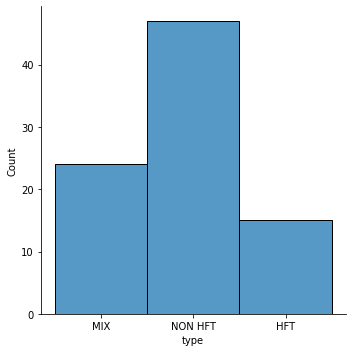

In [ ]:
# Distribution of the target variable
%matplotlib inline

sns.displot(y, x="type")

Le jeu de donnée par trader est plutôt déséquilibré avec plus de NON HFT (1 acteur sur 2) alors qu'il y a peu d'HFT.

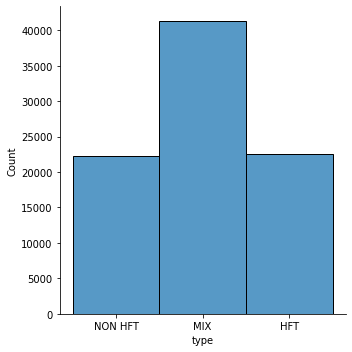

In [ ]:
# Distribution of the target variable
%matplotlib inline

sns.displot(data, x="type")

Le jeu de donnée par ligne change beaucoup, nous avons beaucoup d'information sur les traders MIX alors que l'information sur les traders NON HFT et HFT est équilibrée. A savoir que comme nous l'avons vu précédement ils lestraders MIX sont beaucoup plus nombreux.

### Analyse des caractéristiques qualitatives

In [ ]:
# Affichage du nombre de share et de jours présent dans l'échantillon
print(" Sur la base de train nous avons pour les variables qualitatives :",end="\n\n")
Descr=['Day','Share','Trader']
for i in range(len(Descr)):
    print (" Nombre de " + Descr[i] + " :",len(X[Descr[i]].unique()))

 Sur la base de train nous avons pour les variables qualitatives :

 Nombre de Day : 22
 Nombre de Share : 119
 Nombre de Trader : 86


In [ ]:
# Fonction permettant de calculer pour chaque trader le nombre de jours sur lesquels il a traité 
# et le nombre d'actions différentes sur lesquels il traite
def classif_features(y,X):
  results = y.copy()
  Descr = ['Day','Share']
  for indiv in results.index:
    data = X[X['Trader']==indiv]
    for i in range(len(Descr)):
        results.loc[results.index==indiv, Descr[i]]=len(data[Descr[i]].unique())
  return results

In [ ]:
analyse_data = classif_features(y,X)

In [ ]:
# Création d'un data frame avec pour chaque type de trader le nombre moyen de jours sur lesquels ils ont traité et le nombre moyen d'actions sur lesquels ils traitent
type_trader = ['MIX','NON HFT', 'HFT']
df = pd.DataFrame(columns = ['Day mean', 'Share mean', 'Nbre Traders'], index = type_trader) 
for i in range(len(type_trader)):
    df.loc[df.index==type_trader[i],'Day mean']=analyse_data[analyse_data['type']==type_trader[i]]['Day'].mean()
    df.loc[df.index==type_trader[i],'Share mean']=analyse_data[analyse_data['type']==type_trader[i]]['Share'].mean()
    df.loc[df.index==type_trader[i],'Nbre Traders']=analyse_data[analyse_data['type']==type_trader[i]].count()[1]

trader_HFT = analyse_data[analyse_data['type']=='HFT']
trader_NON_HFT = analyse_data[analyse_data['type']=='NON HFT']
trader_MIX = analyse_data[analyse_data['type']=='MIX']

In [ ]:
df.head(3)

,Day mean,Share mean,Nbre Traders
MIX,21.375,96.458333,24
NON HFT,17.340426,41.93617,47
HFT,20.8,90.133333,15


Nous remarquons que les traders MIX et HTF sont présents en moyenne sur plus de jours et sur beaucoup plus d'actions

Text(0.5, 1.0, 'Distribution MIX')

<Figure size 432x432 with 0 Axes>

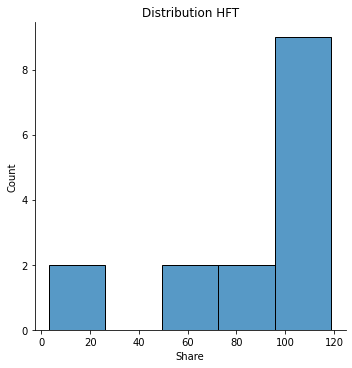

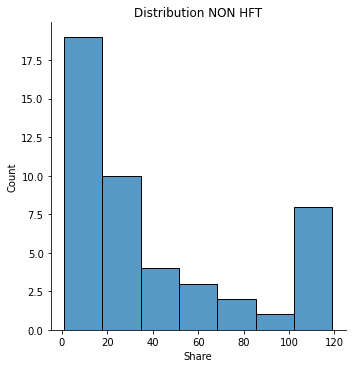

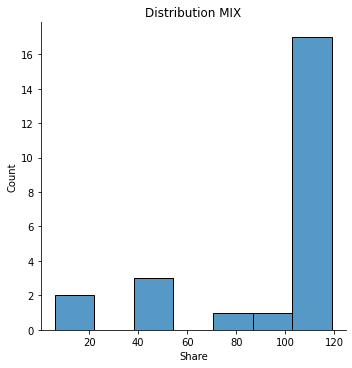

In [ ]:
# Distribution du nombre de shares traités par traders selon le type de traders
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.displot(data=trader_HFT, x='Share')
plt.title("Distribution HFT")
sns.displot(data=trader_NON_HFT, x='Share')
plt.title("Distribution NON HFT")
sns.displot(data=trader_MIX, x='Share')
plt.title("Distribution MIX")

Text(0.5, 1.0, 'Distribution MIX')

<Figure size 432x432 with 0 Axes>

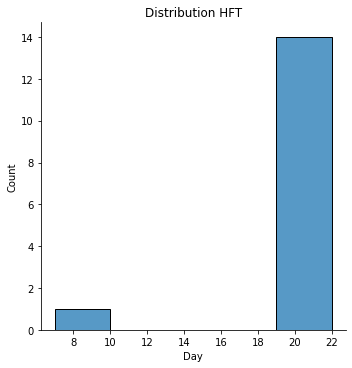

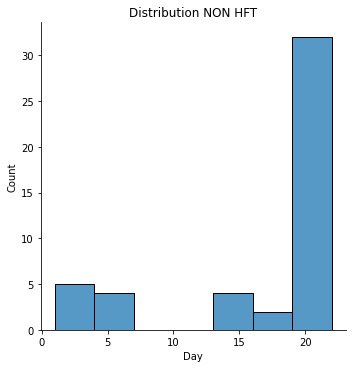

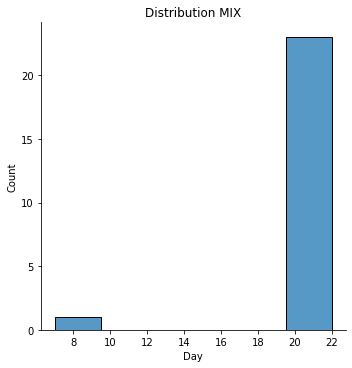

In [ ]:
# Distribution des jours où le trader à traité selon le type de traders
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.displot(data=trader_HFT, x='Day')
plt.title("Distribution HFT")
sns.displot(data=trader_NON_HFT, x='Day')
plt.title("Distribution NON HFT")
sns.displot(data=trader_MIX, x='Day')
plt.title("Distribution MIX")

On remarque que les comportements ne sont pas les mêmes selon la catégorie à laquelle appartient le trader. Ce constat est d'autant plus flagrant lorsqu'on s'intéresse à la distribution du nombre d'actions sur lesquelles ils ont traité. Les HTF traitent en moyenne sur plus d'actions que les NON HTF

Afin d'être sûrs d'avoir exploré toutes les pistes, nous allons regarder si certains actifs ne sont traités que par certains types de trader. Si c'est le cas nous pouvons rajouter un variables indicatrice dans les features.

In [ ]:
# Création d'un data frame afin de voir quelle quantité de chaque catégorie de trader traite sur chaque action
Descr=['Share']
df_share = pd.DataFrame(X[Descr[0]].unique().tolist())

for isin in df_share[0]:
  f = data[data.loc[:,'Share']==isin]
  df_share.loc[df_share.loc[:,0]==isin,'NON HFT']  = f[f.loc[:,'type']=='NON HFT'].count()[0]
  df_share.loc[df_share.loc[:,0]==isin,'HFT']  = f[f.loc[:,'type']=='HFT'].count()[0]
  df_share.loc[df_share.loc[:,0]==isin,'MIX']  = f[f.loc[:,'type']=='MIX'].count()[0]

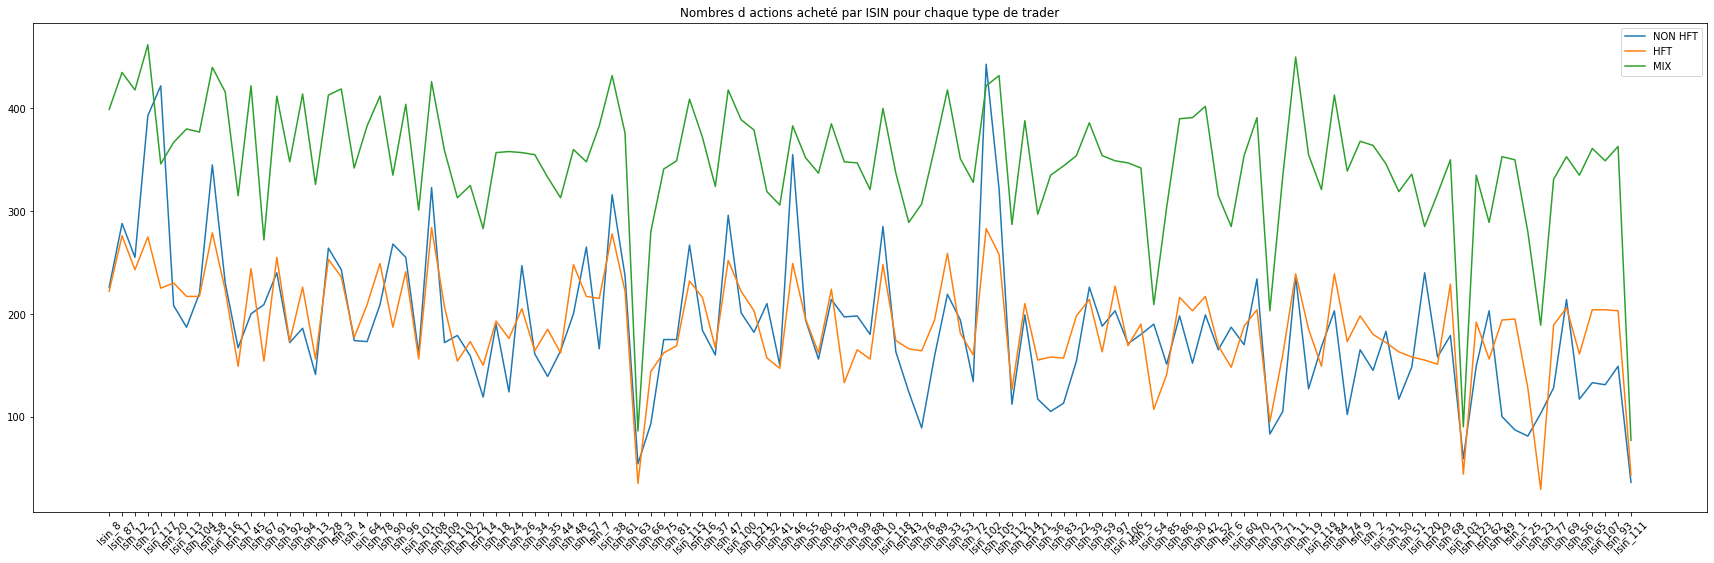

In [ ]:
# Affichage du data frame
plt.figure(figsize=(30, 9))
x = df_share[0]
plt.plot(x, df_share['NON HFT'], label='NON HFT')
plt.plot(x, df_share['HFT'], label='HFT')
plt.plot(x, df_share['MIX'], label='MIX')
plt.title('Nombres d actions acheté par ISIN pour chaque type de trader')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Sans surprise, les trader HTF achètent une plus grande quantité d'actions (le nombre d'actions n'est pas beaucoup plus elevé que celui des NON HTF mais ils sont beaucoup moins nombreux). Il apparait également que le nombre est relativement stable selon les Isin (autour de 150).

In [ ]:
analyse_data['HFT'] = np.nan
analyse_data['NON_HFT'] = np.nan
analyse_data['MIX'] = np.nan

analyse_data.loc[:,'HFT'] =  pd.Series(analyse_data.loc[:,'type']=='HFT')
analyse_data.loc[:,'NON_HFT'] =  pd.Series(analyse_data.loc[:,'type']=='NON HFT')
analyse_data.loc[:,'MIX'] =  pd.Series(analyse_data.loc[:,'type']=='MIX')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


Text(0.5, 1.0, 'Logistic regression y=MIX X=Day')

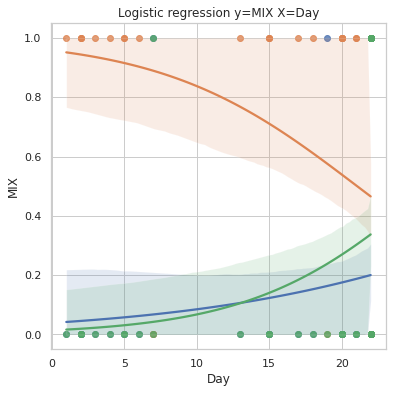

In [ ]:
# regression logistique
%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.regplot(x='Day', y='HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=HFT X=Day")
sns.regplot(x='Day', y='NON_HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=NON HFT X=Day")
sns.regplot(x='Day', y='MIX', data=analyse_data, logistic=True)
plt.title("Logistic regression y=MIX X=Day")

Text(0.5, 1.0, 'Logistic regression y=MIX X=Share')

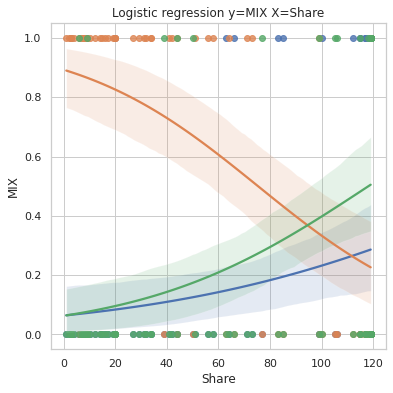

In [ ]:
%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.regplot(x='Share', y='HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=HFT X=Share")
sns.regplot(x='Share', y='NON_HFT', data=analyse_data, logistic=True)
plt.title("Logistic regression y=NON HFT X=Share")
sns.regplot(x='Share', y='MIX', data=analyse_data, logistic=True)
plt.title("Logistic regression y=MIX X=Share")

Nous pouvons remarquer qu'il n'y a pas de relation significative entre le nombre de jour d'activité et le type de trader. En revanche, il apparait que plus un trader traite sur un grand nombre d'action, alors il est plus suceptible d'être un HTF.

### Corrélation des variables

Text(0.5, 1.0, 'Correlation matrix')

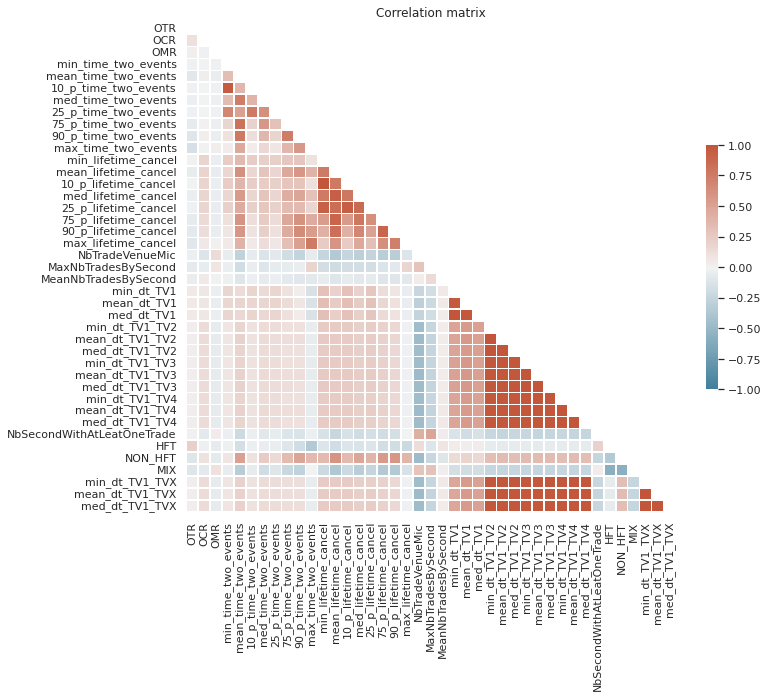

In [ ]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix')

In [ ]:
corr

,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,HFT,NON_HFT,MIX,min_dt_TV1_TVX,mean_dt_TV1_TVX,med_dt_TV1_TVX
OTR,1.000000,0.115914,0.021998,-0.012606,-0.091425,-0.011459,-0.027968,-0.012046,-0.062459,-0.098110,-0.154773,0.001098,-0.052610,-0.000766,-0.036003,-0.011996,-0.057515,-0.071339,-0.089670,-0.028645,-0.066799,-0.043611,0.054311,0.050222,0.051298,0.026236,0.025280,0.026117,0.025782,0.024591,0.025627,0.026012,0.024972,0.025976,-0.011935,0.211317,-0.099953,-0.098382,0.025337,0.024255,0.025226
OCR,0.115914,1.000000,-0.015429,-0.007172,0.023695,-0.005790,-0.001377,-0.000686,0.004357,0.022644,0.003312,0.190905,0.189702,0.189309,0.177126,0.184221,0.154559,0.132545,0.057752,-0.114371,-0.051329,0.047302,0.064826,0.076854,0.067696,0.143456,0.144572,0.143800,0.142597,0.143688,0.142978,0.143340,0.144351,0.143692,-0.071367,-0.016837,0.098488,-0.071471,0.145307,0.146307,0.145675
OMR,0.021998,-0.015429,1.000000,-0.007818,-0.041765,-0.008541,-0.019850,-0.011202,-0.026335,-0.031658,0.028858,-0.038151,-0.051225,-0.038462,-0.043038,-0.040877,-0.045464,-0.039927,0.011645,0.135720,0.071713,0.002419,-0.034744,-0.044222,-0.038119,-0.059113,-0.061343,-0.059671,-0.059532,-0.061625,-0.060061,-0.059121,-0.061362,-0.059668,0.033403,-0.057944,-0.065272,0.108174,-0.058972,-0.061149,-0.059521
min_time_two_events,-0.012606,-0.007172,-0.007818,1.000000,0.334327,0.959836,0.342591,0.671917,0.175303,0.106299,0.036742,0.229465,0.164136,0.226660,0.168477,0.209643,0.112953,0.083385,0.049735,-0.051269,-0.034468,-0.020742,0.176401,0.169994,0.174918,0.082069,0.081308,0.081905,0.082658,0.081894,0.082520,0.081875,0.080997,0.081728,-0.026853,-0.023000,0.085077,-0.054298,0.084178,0.083259,0.084032
mean_time_two_events,-0.091425,0.023695,-0.041765,0.334327,1.000000,0.374981,0.746708,0.523362,0.805772,0.771577,0.469728,0.366670,0.623516,0.382146,0.560235,0.447338,0.588076,0.572389,0.399012,-0.277088,-0.175738,-0.099611,0.140903,0.189683,0.158700,0.192469,0.199427,0.193954,0.194939,0.202084,0.196626,0.192658,0.201088,0.194567,-0.203494,-0.160842,0.518573,-0.312792,0.195745,0.202942,0.197463
10_p_time_two_events,-0.011459,-0.005790,-0.008541,0.959836,0.374981,1.000000,0.397283,0.760565,0.199867,0.121221,0.042857,0.233547,0.171683,0.230911,0.175429,0.215109,0.120004,0.089511,0.052227,-0.057520,-0.040035,-0.023866,0.192403,0.186981,0.191025,0.097610,0.096836,0.097468,0.097851,0.097170,0.097736,0.097284,0.096622,0.097151,-0.030951,-0.027423,0.097663,-0.061432,0.099300,0.098467,0.099174
med_time_two_events,-0.027968,-0.001377,-0.019850,0.342591,0.746708,0.397283,1.000000,0.629855,0.563185,0.369520,0.158151,0.213218,0.290432,0.227486,0.291494,0.267533,0.249882,0.217503,0.125530,-0.123461,-0.105367,-0.055933,0.151491,0.177254,0.157991,0.144275,0.147258,0.144910,0.146828,0.149851,0.147548,0.144499,0.148952,0.145596,-0.090679,-0.046520,0.244378,-0.173166,0.144813,0.148100,0.145636
25_p_time_two_events,-0.012046,-0.000686,-0.011202,0.671917,0.523362,0.760565,0.629855,1.000000,0.310344,0.193290,0.074329,0.211425,0.186114,0.211624,0.183974,0.206151,0.142104,0.116040,0.063966,-0.079576,-0.061718,-0.036185,0.186204,0.192998,0.187314,0.130163,0.130763,0.130264,0.131105,0.131807,0.131238,0.129729,0.130935,0.129888,-0.048354,-0.043230,0.150486,-0.093801,0.129836,0.130511,0.129966
75_p_time_two_events,-0.062459,0.004357,-0.026335,0.175303,0.805772,0.199867,0.563185,0.310344,1.000000,0.743128,0.368078,0.272381,0.462498,0.285837,0.437137,0.34101

On remarque que certaines des corrélations entre nos variables sont très fortes. Il faudra peut être les sélectionner pour éviter des biais (multicolinéarité) dans nos modèles.

### PCA Analysis

L'objectif ici est de s'intéresser à l'importance des variables et leur pouvoir explicatif à travers un analyse en composante principale

In [ ]:
X_pca = data.drop(['Share', 'Day', 'Trader', 'type', 'HFT', 'NON_HFT', 'MIX'], axis=1)

In [ ]:
# 2D plot of PCA decomposition

features = X_pca.columns

pca = PCA(n_components=2)
components = pca.fit_transform(X_pca)
total_var = pca.explained_variance_ratio_.sum() * 100
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=data['type'], opacity = 0.5, title=f'Total Explained Variance: {total_var:.2f}%')

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_traces(marker_size = 4)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Les deux premières composantes principales expliquent à elles seules environ 76% de la variance. On remarque par ailleurs que certains vecteurs propres sont colinéaires, ils n'apportent donc pas d'information supplémentaire.

In [ ]:
# 3D plot of PCA decomposition

pca = PCA(n_components=3)
components = pca.fit_transform(X_pca)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=data['type'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    opacity = 0.5
)
fig.update_traces(marker_size = 2)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

L'analyse en composantes principales montre qu'il suffit de peu de composantes pour expliquer une part importante de la variance, avec 3 composantes 84% de la variance est expliquée. La visualisation sur 3 composantes permet de mieux séparer les classes, la classe NON HFT est opposée à la classe HFT alors que la classe MIX fait le lien entre les 2.

## II) Modélisation

Construction d'un benchmark et de différents modèles

In [ ]:
X_ = data.copy()
X_.drop(['type','HFT','NON_HFT','MIX'], axis=1,inplace=True)
y_ = data['type']

### train test split

Nous choisissons de séparer le jeu de données par traders nous obtenons donc pour chaque trader un jeu de train et de test. Cela permet de garantir un nombre de trader suffisant dans le test set.

In [ ]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame() 

In [ ]:
# Split by trader
for indiv in y.index:
  if X_[X_['Trader']==indiv].shape[0]>1:
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_[X_['Trader']==indiv],y_[X_['Trader']==indiv], test_size=0.4, random_state=42)
    X_train = pd.concat([X_train,X_train_])
    X_test = pd.concat([X_test,X_test_])
    y_train = pd.concat([y_train,y_train_])
    y_test = pd.concat([y_test,y_test_])
  else:
    X_test = pd.concat([X_test,X_[X_['Trader']==indiv]])
    y_test = pd.concat([y_test,y_[X_['Trader']==indiv]])



In [ ]:
#Shuffle the lines
X_train = X_train.sample(frac=1, random_state=42)
y_train = y_train.sample(frac=1, random_state=42)

X_test = X_test.sample(frac=1, random_state=0)
y_test = y_test.sample(frac=1, random_state=0)

In [ ]:
#raws = traders
list_traders_train=X_train['Trader'].copy()
list_traders_test=X_test['Trader'].copy()

In [ ]:
#Drop qualitative features we don't need
X_train.drop(['Day','Trader','Share'], axis=1, inplace=True)
X_test.drop(['Day','Trader','Share'], axis=1, inplace=True)

### Classification 1 : ligne par ligne

#### scoring

Pour la métrique de score nous choisissons le F1 score *weigthed*, c'est à dire que le F1 score est calculé pour chaque label et la moyenne est pondérée afin de régler le problème du jeu de donnée non équilibrée.

$F_1-score = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$

In [ ]:
scoring = make_scorer(f1_score, average='weighted')

#### Preprocessing - scaler

In [ ]:
# Numeric transformer = Imputer + Scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())]) 
SimpleImputer(strategy="constant", fill_value=0) 

# Preproc = transformer (Numeric only here)
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, X_train.columns.tolist())]) 


#### Benchmark Logistic Regression

Pour le benchmark nous utilisons une simple régression logistique.

In [ ]:
clf_bench = Pipeline(steps=[('preprocessor', preproc), ("log_reg",LogisticRegression(random_state=0, max_iter=500))])
         
clf_bench.fit(X_train, y_train[0])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OTR', 'OCR', 'OMR',
                                                   'min_time_two_events',
                                                   'mean_time_two_events',
                                                   '10_p_time_two_events',
                                                   'med_time_two_events',
                                                   '25_p_time_two_events',
                                                   '75_p_time_two_events',
                                           

In [ ]:
print('Results for benchmark')
print('Features names: {}'.format(clf_bench.feature_names_in_))
print('Returned hyperparameter: {}'.format(clf_bench[1].coef_))

Results for benchmark
Features names: ['OTR' 'OCR' 'OMR' 'min_time_two_events' 'mean_time_two_events'
 '10_p_time_two_events' 'med_time_two_events' '25_p_time_two_events'
 '75_p_time_two_events' '90_p_time_two_events' 'max_time_two_events'
 'min_lifetime_cancel' 'mean_lifetime_cancel' '10_p_lifetime_cancel'
 'med_lifetime_cancel' '25_p_lifetime_cancel' '75_p_lifetime_cancel'
 '90_p_lifetime_cancel' 'max_lifetime_cancel' 'NbTradeVenueMic'
 'MaxNbTradesBySecond' 'MeanNbTradesBySecond' 'min_dt_TV1' 'mean_dt_TV1'
 'med_dt_TV1' 'min_dt_TV1_TV2' 'mean_dt_TV1_TV2' 'med_dt_TV1_TV2'
 'min_dt_TV1_TV3' 'mean_dt_TV1_TV3' 'med_dt_TV1_TV3' 'min_dt_TV1_TV4'
 'mean_dt_TV1_TV4' 'med_dt_TV1_TV4' 'NbSecondWithAtLeatOneTrade'
 'min_dt_TV1_TVX' 'mean_dt_TV1_TVX' 'med_dt_TV1_TVX']
Returned hyperparameter: [[ 1.25101395e+00 -7.29899044e-02 -2.67591259e-01  2.38929320e-01
  -9.31185069e-02 -2.03319659e-01  1.02174283e-01  1.53813065e-02
   1.89498606e-01  2.06732137e-01 -7.27744876e-01 -4.68673392e-01
  -1.35

In [ ]:
# Génération des labels selon le modèle obtenu au dessus
y_pred_train_bench = clf_bench.predict(X_train)
y_pred_test_bench = clf_bench.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_bench, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_bench, average='weighted')))

Best classification accuracy in train is: 0.791943169218749
Best classification accuracy in test is: 0.7918577310439312


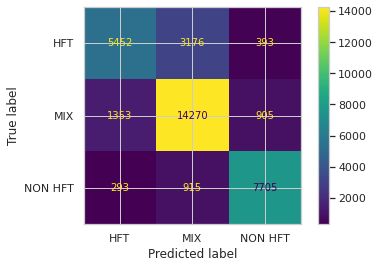

In [ ]:
# atrice de confusion
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

A noter que nous avons essayé différentes variations autour de la régression logistique avec l'ajout d'une pénalité L1 et l'utilisation d'une transformation en composantes principales.

La première solution rencontrait des forts problèmes de convergence, les résultats n'étaient pas meilleurs que le benchmark.

La seconde n'apportait pas non plus de résultats meilleurs que le benchmark.

#### Régression logisitique polynomiale

Une approche assez simple pour améliorer ce benchmark peut être d'utiliser une transformation en composante principale, une pénalisation, ou une transformation polynomiale. Nous choisissons la transformation polynomiale et observons une amélioration significative des résultats.

In [ ]:
clf_log_poly = Pipeline(steps=[('preprocessor', preproc),('poly', PolynomialFeatures(2)),
                                ("log_reg_pca",LogisticRegression(random_state=0, max_iter=1000))])

clf_log_poly.fit(X_train, y_train[0])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OTR', 'OCR', 'OMR',
                                                   'min_time_two_events',
                                                   'mean_time_two_events',
                                                   '10_p_time_two_events',
                                                   'med_time_two_events',
                                                   '25_p_time_two_events',
                                                   '75_p_time_two_events',
                                           

In [ ]:
y_pred_train_log_poly = clf_log_poly.predict(X_train)
y_pred_test_log_poly = clf_log_poly.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_log_poly, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_log_poly, average='weighted')))

Best classification accuracy in train is: 0.8936252374040611
Best classification accuracy in test is: 0.889072328283996


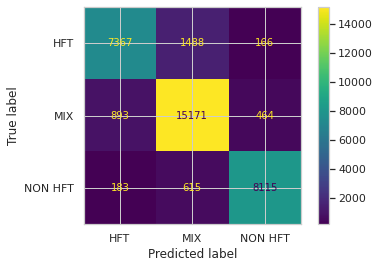

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_log_poly),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### SVC pénalité l1

Nous utilisons à présent un Linear Support Vector Classification. Le jeu de données étant relativement gros l'implémentation d'un SVC est par ailleurs assez difficile, le temps de calcul étant assez élevé, nous rencontrons des problèmes de convergences (nombre d'itération faible)

In [ ]:
# Validation croisée du modèle

models = [("svc", LinearSVC(max_iter=200, penalty='l1', tol=1e-4, random_state=42, dual=False))]
grids = {"svc" : {'svc__C': [1, 2]}}
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=2, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Results for svc
Returned hyperparameter: {'svc__C': 2}
Best classification accuracy in train is: 0.7664710672377973
Classification accuracy on test is: 0.7674354912019197


In [ ]:

modelOPt_svc=clf.best_estimator_
modelOPt_svc.fit(X_train, y_train)

y_pred_train_svc = modelOPt_svc.predict(X_train)
y_pred_test_svc = modelOPt_svc.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_svc, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_svc, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Best classification accuracy in train is: 0.7666389877334331
Best classification accuracy in test is: 0.7674354912019197


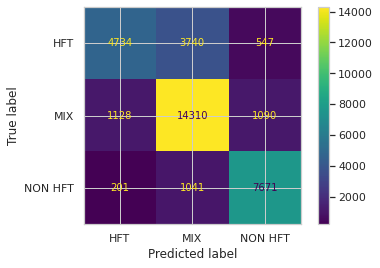

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_svc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### KNN

What about k-nearest neighbors vote ?

Nous essayons les KNN sur les résulats de l'ACP.

In [ ]:
# Validation croisée du modèle
models = [("knn", KNeighborsClassifier())]
grids = {"knn" : {  'knn__n_neighbors': [3, 5, 10, 50]}}
pca = PCA(n_components=25)
      
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), ('pca', pca),(name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Results for knn
Returned hyperparameter: {'knn__n_neighbors': 5}
Best classification accuracy in train is: 0.9095130496972903
Classification accuracy on test is: 0.915732188895311


In [ ]:
modelOPt_knn=clf.best_estimator_
modelOPt_knn.fit(X_train, y_train)

y_pred_train_knn = modelOPt_knn.predict(X_train)
y_pred_test_knn = modelOPt_knn.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_knn, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_knn, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best classification accuracy in train is: 0.9386379146797978
Best classification accuracy in test is: 0.915732188895311


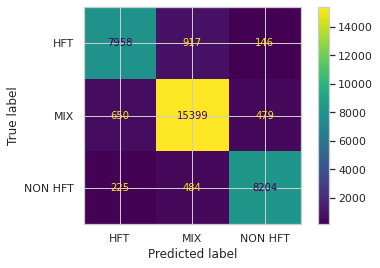

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_knn),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

Pas mal pour un alogrithme simple avec k=5 !

#### Random Forest

Une forêt aléatoire est souvent un algorithme efficace pour une classification.

In [ ]:
# Validation croisée du modèle
models = [("rdm_frt", RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=100))]
grids = {"rdm_frt" : {  'rdm_frt__max_depth': [10, 50],
                         'rdm_frt__min_samples_split': [2, 5]}
        }
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=2, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Results for rdm_frt
Returned hyperparameter: {'rdm_frt__max_depth': 50, 'rdm_frt__min_samples_split': 2}
Best classification accuracy in train is: 0.971257718116747
Classification accuracy on test is: 0.9772890194000922


In [ ]:
modelOPt_rf=clf.best_estimator_
modelOPt_rf.fit(X_train, y_train)

y_pred_train_rf = modelOPt_rf.predict(X_train)
y_pred_test_rf = modelOPt_rf.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_rf, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_rf, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best classification accuracy in train is: 1.0
Best classification accuracy in test is: 0.9772890194000922


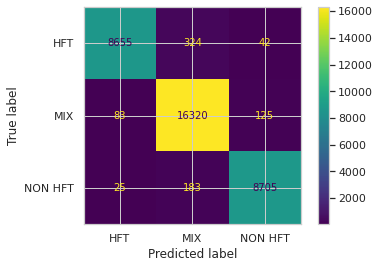

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_rf),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

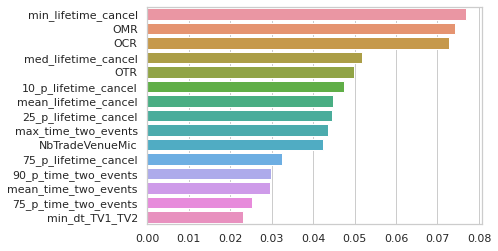

In [ ]:
# Affichage de l'importance des features
%matplotlib inline

#Récupérer les features transformées
features=clf.estimator.named_steps['preprocessor'].transformers[0][2]
feature_importances = pd.DataFrame(modelOPt_rf['rdm_frt'].feature_importances_ ,index=features).transpose()

# Affichage de l'importance des 15 premières features
feature_importances_sort=feature_importances[feature_importances.mean().sort_values(ascending=False).index[:15]]
sns.barplot(data=feature_importances_sort, orient='h')

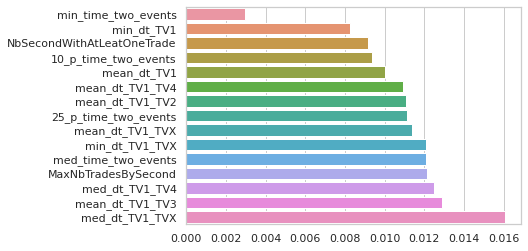

In [ ]:
# Affichage de l'importance des 15 dernières features
feature_importances_sort=feature_importances[feature_importances.mean().sort_values(ascending=True).index[:15]]
sns.barplot(data=feature_importances_sort, orient='h')

En effet, les résultats semblent très bons.
Par ailleurs certaines variables sont peu explicatives.

#### Boosting

Est-il possible de faire mieux que la forêt aléatoire ?
Peut-être avec un Histogram-based Gradient Boosting Classification Tree ?

In [ ]:
# Validation croisée du modèle

models = [("hgbc", HistGradientBoostingClassifier(random_state=42))]
grids = {"hgbc" : {  'hgbc__max_depth': [10, 20, 50],
                         'hgbc__max_iter': [50, 100]}
        }
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train[0])
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Results for hgbc
Returned hyperparameter: {'hgbc__max_depth': 10, 'hgbc__max_iter': 100}
Best classification accuracy in train is: 0.9881986510937822
Classification accuracy on test is: 0.9893773393122114


In [ ]:
modelOPt_hgbc=clf.best_estimator_
modelOPt_hgbc.fit(X_train, y_train)

y_pred_train_hgbc = modelOPt_hgbc.predict(X_train)
y_pred_test_hgbc = modelOPt_hgbc.predict(X_test)

print('Best classification accuracy in train is: {}'.format(f1_score(y_train, y_pred_train_hgbc, average='weighted')))
print('Best classification accuracy in test is: {}'.format(f1_score(y_test, y_pred_test_hgbc, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best classification accuracy in train is: 0.9987212108147813
Best classification accuracy in test is: 0.9893773393122114


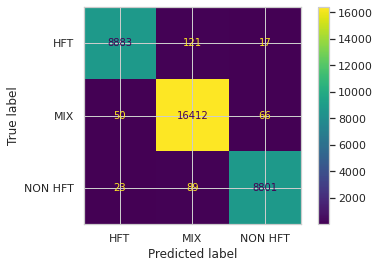

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_hgbc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

### Classification 2 : traders

Jusqu'ici nous avons classifié chaque transaction pour savoir à quel type de trader elle pouvait correspondre. Nous avons donc des résultats potentiellement différents pour toutes les lignes associées à un trader (pour rappel, une ligne correspond à l'ensemble des transaction effectuées par un trader sur une action à une date). Nous souhaitons maintenant classifier chaque trader selon les caractéristiques de ses transaction. Par exemple nous pouvons dire que si 70% des transactions d'un trader ont le label HFT, 15% ont le label MIX et 15% le label NON HFT alors il est un trader HFT. Afin de connaître les poids optimaux nous précédons à une régression logistique ce qui nous permet d'avoir une règle de décision simple et optimale.

#### Preprocessing

In [ ]:
# Fonction permettant de transformer les résulats des classification des lignes des traders en %
def classif_percent(y,list_traders):

  df_y = pd.Series(y, index=list_traders.index, name='y')
  df = pd.concat([df_y, list_traders], axis=1)
  df['count']=1

  table = pd.pivot_table(df, values='y', index=['Trader'], columns=['y'], aggfunc=np.sum)
  table.fillna(0,inplace=True)

  results = table/pd.DataFrame([table.sum(axis=1)]*3,['HFT','MIX','NON HFT']).T
  
  return results

In [ ]:
final_classif = LogisticRegression(random_state=0)

#### Benchmark

In [ ]:
X_bench_trader_train = classif_percent(y_pred_train_bench,list_traders_train)
X_bench_trader_test = classif_percent(y_pred_test_bench,list_traders_test)

In [ ]:
final_classif.fit(X_bench_trader_train, y['type'].loc[X_bench_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_bench = final_classif.predict(X_bench_trader_train)
y_pred_trader_test_bench = final_classif.predict(X_bench_trader_test)

##### Confusion Matrix

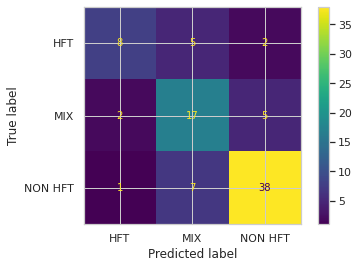

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

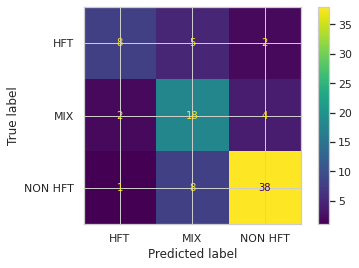

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Régression logisitique polynomiale

In [ ]:
X_log_poly_trader_train = classif_percent(y_pred_train_log_poly,list_traders_train)
X_log_poly_trader_test = classif_percent(y_pred_test_log_poly,list_traders_test)

final_classif.fit(X_log_poly_trader_train, y['type'].loc[X_log_poly_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_log_poly = final_classif.predict(X_log_poly_trader_train)
y_pred_trader_test_log_poly = final_classif.predict(X_log_poly_trader_test)

##### Confusion Matrix

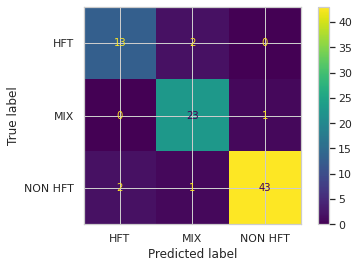

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_log_poly_trader_train.index], y_pred_trader_train_log_poly),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

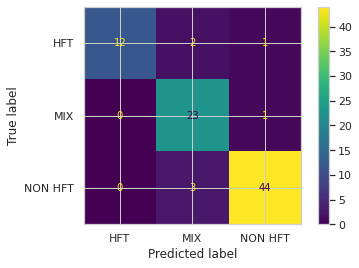

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_log_poly_trader_test.index], y_pred_trader_test_log_poly),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### SVC

In [ ]:
X_svc_trader_train = classif_percent(y_pred_train_svc,list_traders_train)
X_svc_trader_test = classif_percent(y_pred_test_svc,list_traders_test)

final_classif.fit(X_svc_trader_train, y['type'].loc[X_svc_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_svc = final_classif.predict(X_svc_trader_train)
y_pred_trader_test_svc = final_classif.predict(X_svc_trader_test)

##### Confusion Matrix

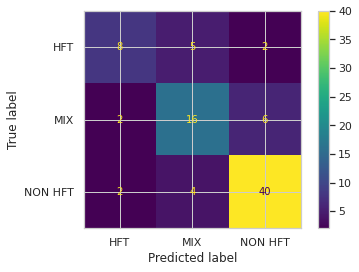

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_svc_trader_train.index], y_pred_trader_train_svc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

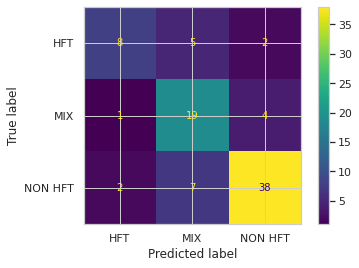

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_svc_trader_test.index], y_pred_trader_test_svc),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### KNN

In [ ]:
X_knn_trader_train = classif_percent(y_pred_train_knn,list_traders_train)
X_knn_trader_test = classif_percent(y_pred_test_knn,list_traders_test)

In [ ]:
final_classif.fit(X_knn_trader_train, y['type'].loc[X_knn_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_knn = final_classif.predict(X_knn_trader_train)
y_pred_trader_test_knn = final_classif.predict(X_knn_trader_test)

##### Confusion Matrix

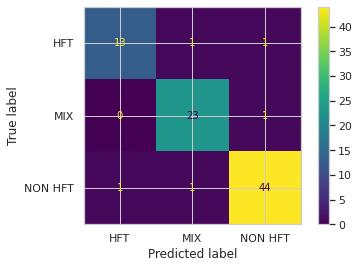

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_knn_trader_train.index], y_pred_trader_train_knn),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

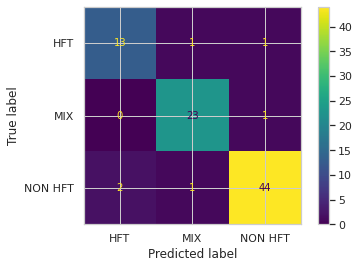

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_knn_trader_test.index], y_pred_trader_test_knn),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Random Forest

In [ ]:
X_rf_trader_train = classif_percent(y_pred_train_rf,list_traders_train)
X_rf_trader_test = classif_percent(y_pred_test_rf,list_traders_test)

In [ ]:
final_classif.fit(X_rf_trader_train, y['type'].loc[X_rf_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_rf = final_classif.predict(X_rf_trader_train)
y_pred_trader_test_rf = final_classif.predict(X_rf_trader_test)

##### Confusion Matrix

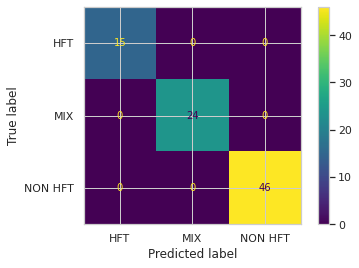

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_rf_trader_train.index], y_pred_trader_train_rf),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

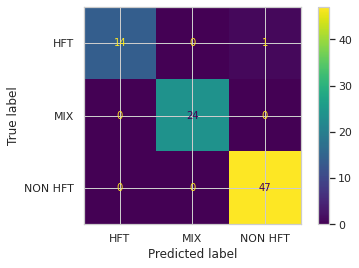

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_rf_trader_test.index], y_pred_trader_test_rf),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

#### Boosting

In [ ]:
X_hgbc_trader_train = classif_percent(y_pred_train_hgbc,list_traders_train)
X_hgbc_trader_test = classif_percent(y_pred_test_hgbc,list_traders_test)

In [ ]:
final_classif.fit(X_hgbc_trader_train, y['type'].loc[X_hgbc_trader_train.index])

LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_hgbc = final_classif.predict(X_hgbc_trader_train)
y_pred_trader_test_hgbc = final_classif.predict(X_hgbc_trader_test)

##### Confusion Matrix

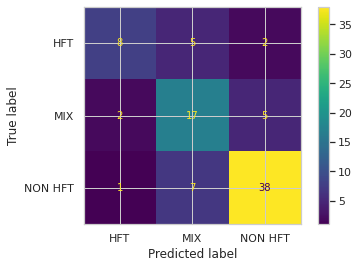

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_train.index], y_pred_trader_train_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

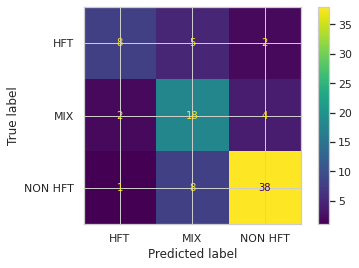

In [ ]:
%matplotlib inline
disp = ConfusionMatrixDisplay(confusion_matrix(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),display_labels = ['HFT','MIX','NON HFT'])
disp.plot()
plt.show()

## III) Comparaison et conclusion

### Comparaison des modèles

La comparaison des modèles se fait sur les résultats sur le test set.

#### Classification 1 : par ligne

In [ ]:
# Create a data frame with the models perfoamnce metrics scores
models_scores_table = pd.DataFrame({'Logistic Regression':[accuracy_score(y_test, y_pred_test_bench),
                                                           precision_score(y_test, y_pred_test_bench, average='weighted'),
                                                           recall_score(y_test, y_pred_test_bench, average='weighted'),
                                                           balanced_accuracy_score(y_test, y_pred_test_bench),
                                                         f1_score(y_test, y_pred_test_bench, average='weighted')],
                                    
                                    'Logistic Regression Polynomial (2)':[accuracy_score(y_test, y_pred_test_log_poly),
                                                          precision_score(y_test, y_pred_test_log_poly, average='weighted'),
                                                          recall_score(y_test, y_pred_test_log_poly, average='weighted'),
                                                          balanced_accuracy_score(y_test, y_pred_test_log_poly),
                                                         f1_score(y_test, y_pred_test_log_poly, average='weighted')],
                                    
                                  'Support Vector Classifier':[accuracy_score(y_test, y_pred_test_svc),
                                                          precision_score(y_test, y_pred_test_svc, average='weighted'),
                                                          recall_score(y_test, y_pred_test_svc, average='weighted'),
                                                          balanced_accuracy_score(y_test, y_pred_test_svc),
                                                         f1_score(y_test, y_pred_test_svc, average='weighted')],
                                    
                                    'K-Nearest Neighbors':[accuracy_score(y_test, y_pred_test_knn),
                                                          precision_score(y_test, y_pred_test_knn, average='weighted'),
                                                          recall_score(y_test, y_pred_test_knn, average='weighted'),
                                                   balanced_accuracy_score(y_test, y_pred_test_knn),
                                                         f1_score(y_test, y_pred_test_knn, average='weighted')],
                                    
                                  'Random Forest':[accuracy_score(y_test, y_pred_test_rf),
                                                          precision_score(y_test, y_pred_test_rf, average='weighted'),
                                                          recall_score(y_test, y_pred_test_rf, average='weighted'),
                                                   balanced_accuracy_score(y_test, y_pred_test_rf),
                                                         f1_score(y_test, y_pred_test_rf, average='weighted')],
                                    
                                  'Histogram Gradient Boosting':[accuracy_score(y_test, y_pred_test_hgbc),
                                                          precision_score(y_test, y_pred_test_hgbc, average='weighted'),
                                                          recall_score(y_test, y_pred_test_hgbc, average='weighted'),
                                                          balanced_accuracy_score(y_test, y_pred_test_hgbc),
                                                         f1_score(y_test, y_pred_test_hgbc, average='weighted')]},
                                  
                                  index=['Accuracy', 'Precision', 'Recall', 'balanced_accuracy_score', 'F1 Score'])

# Add 'Best Score' column
models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

In [ ]:
models_scores_table.head(5)

,Logistic Regression,Logistic Regression Polynomial (2),Support Vector Classifier,K-Nearest Neighbors,Random Forest,Histogram Gradient Boosting,Best Score
Accuracy,0.795862,0.889472,0.775202,0.915820,0.977308,0.989380,Histogram Gradient Boosting
Precision,0.795150,0.889619,0.777028,0.915766,0.977455,0.989391,Histogram Gradient Boosting
Recall,0.795862,0.889472,0.775202,0.915820,0.977308,0.989380,Histogram Gradient Boosting
balanced_accuracy_score,0.777406,0.881672,0.750411,0.911436,0.974502,0.988373,Histogram Gradient Boosting
F1 Score,0.791858,0.889072,0.767435,0.915732,0.977289,0.989377,Histogram Gradient Boosting


On remarque que les resultats de classification sont homogènes sur les différents scores. La Random Forest performe très bien, mais l'Histogram-based Gradient Boosting performe encore mieux.

#### Classification 2 : par trader

In [ ]:
# Create a data frame with the models perfoamnce metrics scores
models_scores_table2 = pd.DataFrame({'Logistic Regression':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench, average='weighted'),
                                                          balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_bench, average='weighted')],
                                    
                                    'Logistic Regression Polynomial (2)':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_log_poly),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_log_poly, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_log_poly, average='weighted'),
                                                          balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_log_poly),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_log_poly, average='weighted')],
                                    
                                  'Support Vector Classifier':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_svc),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_svc, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_svc, average='weighted'),
                                                          balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_svc),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_svc, average='weighted')],
                                     
                                     'K-Nearest Neighbors':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_knn),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_knn, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_knn, average='weighted'),
                                                   balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_knn),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_knn, average='weighted')],
                                    
                                  'Random Forest':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_rf),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_rf, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_rf, average='weighted'),
                                                   balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_rf),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_rf, average='weighted')],
                                    
                                  'Histogram Gradient Boosting':[accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_hgbc),
                                                          precision_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_hgbc, average='weighted'),
                                                          recall_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_hgbc, average='weighted'),
                                                          balanced_accuracy_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_hgbc),
                                                         f1_score(y['type'].loc[X_bench_trader_test.index], y_pred_trader_test_hgbc, average='weighted')]},
                                  
                                  index=['Accuracy', 'Precision', 'Recall', 'balanced_accuracy_score', 'F1 Score'])

# Add 'Best Score' column
models_scores_table2['Best Score'] = models_scores_table2.idxmax(axis=1)

In [ ]:
models_scores_table2.head(5)

,Logistic Regression,Logistic Regression Polynomial (2),Support Vector Classifier,K-Nearest Neighbors,Random Forest,Histogram Gradient Boosting,Best Score
Accuracy,0.744186,0.918605,0.755814,0.930233,0.988372,0.988372,Random Forest
Precision,0.760878,0.926405,0.769880,0.930657,0.988614,0.988614,Random Forest
Recall,0.744186,0.918605,0.755814,0.930233,0.988372,0.988372,Random Forest
balanced_accuracy_score,0.697281,0.898168,0.711170,0.920390,0.977778,0.977778,Random Forest
F1 Score,0.746426,0.919037,0.756574,0.930276,0.988233,0.988233,Random Forest


On remarque que les résultats de la seconde classification (celle des traders) est cohérente avec les résultats de classification des trades. Les algorithmes qui ont bien performés sur la classification des trades, une fois passé dans la régression logistique donnent des bons résultats.

Par ailleurs la Random Forest et l'Histogram-based Gradient Boosting, donne la même performance sur cette classification, cela est lié au peu de Traders que nous avons dans notre jeu de données.

### Conclusion

Dans ce projet nous avons comparé différents algorithmes dans le but de classifier des traders selon leurs type : HFT, NON HFT, MIX. Nos résultats sont relativement concluant puisque nous avons des scores très élevés notament avec la Random Forest et l'histogram based Gradient Boosting. Sur les échantillons de test nous obtenons jusqu'à 100% de classifications correctes. Il aurait cependant été interessant d'essayer de travailler avec moins de features d'autant plus que elles sont couteuses à récuperer. Mais nous avons vu que la pénalisation L1 était coûteuse en temps de calcul sur un dataset de cette importance.

## IV) Application au test set

Nous allons enfin appliquer le meilleur modèle utilisé afin de le soumettre au data challenge !

### Data cleaning

In [ ]:
#Suppression des doublons (20 000 raws)
X_val.drop_duplicates(inplace=True)

#Création du data Frame data regroupant X et y et ajout des variables y comme binaires
data_val=X_val.copy()

In [ ]:
# Ajout de featrues pour TV1_TVX

data_val['min_dt_TV1_TVX'] = np.nan
data_val['mean_dt_TV1_TVX'] = np.nan
data_val['med_dt_TV1_TVX'] = np.nan

data_val.loc[:,'min_dt_TV1_TVX'] =  data[['min_dt_TV1_TV2','min_dt_TV1_TV3','min_dt_TV1_TV4']].mean(axis=1)
data_val.loc[:,'mean_dt_TV1_TVX'] =  data[['mean_dt_TV1_TV2','mean_dt_TV1_TV3','mean_dt_TV1_TV4']].mean(axis=1)
data_val.loc[:,'med_dt_TV1_TVX'] =  data[['med_dt_TV1_TV2','med_dt_TV1_TV3','med_dt_TV1_TV4']].mean(axis=1)

In [ ]:
# On remarque que ces variables ne comportent pas de 0 il faut remplacer les NaN (pas de d'annulation/modification de transaction)
data_val['OMR'].fillna(0,inplace=True)
data_val['OTR'].fillna(0,inplace=True)

In [ ]:
# Le reste des valeurs manquante est alors lié aux autres plateformes de trading (l'acteur n'y a pas participé), on remplie alors la valeur de la ligne par la valeur max du trader

# Voir avec Mean et Max
for indiv in data_val['Trader'].unique():
   data_val[data_val.loc[:,'Trader']==indiv] = data_val[data_val.loc[:,'Trader']==indiv].fillna(data_val.loc[data_val.loc[:,'Trader']==indiv,:].max())

In [ ]:
# Si la data n'a toujours pas été remplie c'est qu'il n'y a pas eu de traitement on lui affecte la valeur max
data_val.fillna(data.max(),inplace=True)

In [ ]:
X_val_ = data.copy()

### Classification 1

In [ ]:
# Validation croisée du modèle

models = [("hgbc", HistGradientBoostingClassifier(random_state=42))]
grids = {"hgbc" : {  'hgbc__max_depth': [10, 20, 50],
                         'hgbc__max_iter': [50, 100]}
        }
         
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3, scoring=scoring, verbose=1, n_jobs=-1)
    clf.fit(X_, y_)
    print('Results for {}'.format(name))
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Results for hgbc
Returned hyperparameter: {'hgbc__max_depth': 10, 'hgbc__max_iter': 100}
Best classification accuracy in train is: 0.7570595391449135


In [ ]:
modelOPt_hgbc_val=clf.best_estimator_
modelOPt_hgbc_val.fit(X_, y_)

y_pred_train_hgbc_val = modelOPt_hgbc_val.predict(X_)
y_pred_hgbc_val = modelOPt_hgbc_val.predict(data_val)

print('Best classification accuracy in train is: {}'.format(f1_score(y_, y_pred_train_hgbc_val, average='weighted')))

Best classification accuracy in train is: 0.9978390383804858


### Calssification 2

In [ ]:
X_hgbc_trader_train_val = classif_percent(y_pred_train_hgbc_val,data['Trader'])
X_hgbc_trader_val = classif_percent(y_pred_hgbc_val,data_val['Trader'])

In [ ]:
final_classif.fit(X_hgbc_trader_train_val.loc[y.index], y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(random_state=0)

In [ ]:
y_pred_trader_train_hgbc_val = final_classif.predict(X_hgbc_trader_train_val)
y_pred_trader_hgbc_val = final_classif.predict(X_hgbc_trader_val)

In [ ]:
y_val_pred = pd.Series(y_pred_trader_hgbc_val, index=X_hgbc_trader_val.index)

In [ ]:
y_val_pred

Trader
Adelaide            NON HFT
Alana               NON HFT
Alcmene             NON HFT
Alice                   HFT
Alices Sister       NON HFT
                     ...   
Monstro                 MIX
Morgana                 MIX
The Doorknob            HFT
The Doorman             HFT
The Magic Mirror        MIX
Length: 85, dtype: object

Ce jeu de données peut à présent être soumis pour le data challenge

In [ ]:
y_val_pred.to_csv('data_challenge_amf_y.csv',index=True)


In [ ]:
from google.colab import files
files.download('data_challenge_amf_y.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Et notre score final (bonnes classifications) selon le data challenge est ... 

95.24% plutôt pas mal !

:-)